# Classifying Names with an RNN

In this notebook I'll show how to classifying names in PyTorch with the built-in [RNN class](https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN).

## Loading the Names Dataset

Recall that the names data contains a few thousand surnames from 18 languages of origin. 
In the Preparing the Names Data [notebook](https://nbviewer.jupyter.org/github/bobflagg/classifying-names/blob/master/Preparing-Names-Data.ipynb) the data was split into training and test datasets and encoded/embedded so that a batch of names is represented as a tensor with dimension n-batch x seq-len x num-chars and a corresponding batch of labels as a tensor with dimension an n-batch.  I've put the preprocessing code in the [names module](https://github.com/bobflagg/classifying-names/blob/master/names.py) so we can easily load it using the NamesDataset class.

In [7]:
from names import NamesDataset

batch_size = 16
dataset = NamesDataset(directory='./data/names/', verbose=False)
train_loader, test_loader = dataset.build_data_loaders(batch_size)
X, y = iter(train_loader).next()
seq_len, num_chars, num_classes = dataset.seq_len, dataset.num_chars, dataset.num_classes
languages = dataset.languages
print("Names batch shape/type:", X.shape, "/", X.dtype)
print("Labels batch shape/type:", y.shape, "/", y.dtype)

Names batch shape/type: torch.Size([16, 19, 57]) / torch.float32
Labels batch shape/type: torch.Size([16]) / torch.float32


## A Simple RNN Classifier

PyTorch makes this extremely easy by providing an off-the-shelf RNN class.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class NameClassifierRNN(nn.Module):
    def __init__(self, batch_size, num_chars, n_hidden, num_classes):
        super(NameClassifierRNN, self).__init__()
        
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.num_chars = num_chars
        self.num_classes = num_classes
        
        self.basic_rnn = nn.RNN(self.num_chars, self.n_hidden) 
        self.FC = nn.Linear(self.n_hidden, self.num_classes)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        hidden = (torch.zeros(1, self.batch_size, self.n_hidden))
        if torch.cuda.is_available(): hidden = hidden.cuda()
        return hidden     
    
    def forward(self, X):
        # transforms X to dimensions: seq-len x batch-size x num-chars
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.num_classes) # batch_size X n_output

The following method will be used to compute training and test accuracy during training.

In [3]:
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.long().data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

The training method is pretty generic.  

In [22]:
def train(model, batch_size, seq_len, num_chars, epochs=10, lr=0.001):
    train_on_gpu = torch.cuda.is_available()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    all_train_acc = [1.0 / num_classes]
    all_test_acc = [1.0 / num_classes]

    for epoch in range(epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        model.train()

        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            model.hidden = model.init_hidden() 
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.view(-1, seq_len, num_chars) 
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(outputs, labels, batch_size)

        epoch_loss = 100 * train_running_loss / i
        epoch_train_acc = train_acc / i
        all_train_acc.append(epoch_train_acc)

        model.eval()
        test_acc = 0.0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.view(-1, seq_len, num_chars) 
            outputs = model(inputs)
            test_acc += get_accuracy(outputs, labels, batch_size)
        epoch_test_acc = test_acc / i
        all_test_acc.append(epoch_test_acc)
        print(
            'Epoch:  %2d | Loss: %4.2f | Train Accuracy: %.2f | Test Accuracy: %.2f' %
            (epoch + 1, epoch_loss, epoch_train_acc, epoch_test_acc)
        )
    return all_train_acc, all_test_acc


The simple model has only one parameter that can be adjusted: 
the number of hidden units of the RNN cell.  I'll set this at 128 for testing but feel free to experiment with other values.

In [23]:
model = NameClassifierRNN(batch_size, num_chars, 128, num_classes)
if torch.cuda.is_available(): model.cuda()
print(model)

NameClassifierRNN(
  (basic_rnn): RNN(57, 128)
  (FC): Linear(in_features=128, out_features=18, bias=True)
)


I won't worry about tuning the parameters for training.  My goal for now is to just to verify that everything works as expected and to establish a simple baseline for name classification.

In [24]:
%%time
all_train_acc, all_test_acc = train(model, batch_size, seq_len, num_chars, epochs=16, lr=0.001)

Epoch:   1 | Loss: 131.48 | Train Accuracy: 60.92 | Test Accuracy: 69.91
Epoch:   2 | Loss: 94.97 | Train Accuracy: 71.65 | Test Accuracy: 73.08
Epoch:   3 | Loss: 84.78 | Train Accuracy: 74.30 | Test Accuracy: 74.97
Epoch:   4 | Loss: 78.12 | Train Accuracy: 76.06 | Test Accuracy: 76.47
Epoch:   5 | Loss: 73.75 | Train Accuracy: 76.98 | Test Accuracy: 76.60
Epoch:   6 | Loss: 69.88 | Train Accuracy: 78.10 | Test Accuracy: 78.54
Epoch:   7 | Loss: 66.77 | Train Accuracy: 78.95 | Test Accuracy: 77.52
Epoch:   8 | Loss: 64.07 | Train Accuracy: 79.79 | Test Accuracy: 77.93
Epoch:   9 | Loss: 61.42 | Train Accuracy: 80.51 | Test Accuracy: 78.77
Epoch:  10 | Loss: 58.54 | Train Accuracy: 81.50 | Test Accuracy: 79.17
Epoch:  11 | Loss: 56.47 | Train Accuracy: 81.90 | Test Accuracy: 78.80
Epoch:  12 | Loss: 54.37 | Train Accuracy: 82.61 | Test Accuracy: 78.90
Epoch:  13 | Loss: 52.73 | Train Accuracy: 82.68 | Test Accuracy: 80.31
Epoch:  14 | Loss: 50.37 | Train Accuracy: 83.31 | Test Accurac

Well, 80% accuracy is not bad for this problem.  Let's look at the learning curves.

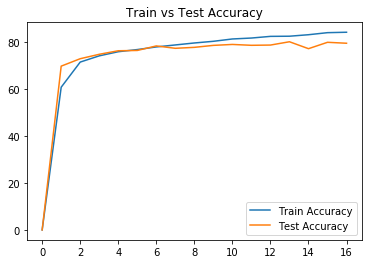

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_accuracy(model, test_acc, train_acc):
    plt.figure()
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.title("Train vs Test Accuracy")

show_accuracy(model, all_test_acc, all_train_acc)

As show in the [name classification with RNNs example](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) a confusion matrix will give us a better idea of where the errors are.

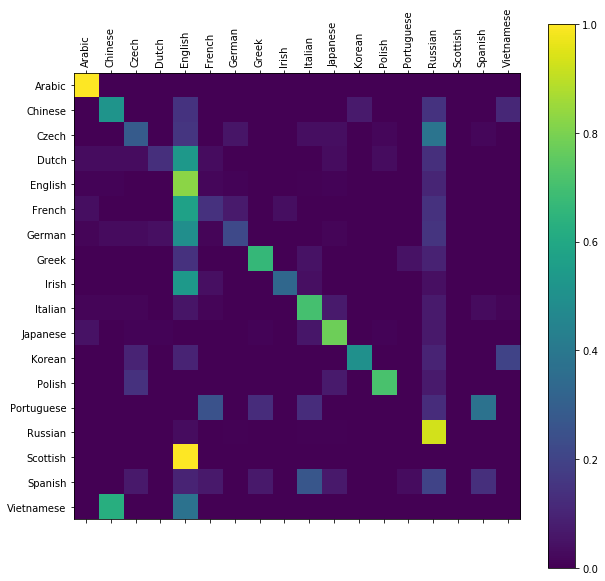

In [26]:
def show_confusion(model, loader, languages, seq_len):

    train_on_gpu = torch.cuda.is_available()
    num_classes = len(languages)

    confusion = torch.zeros(num_classes, num_classes)
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if (train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(-1, seq_len, num_chars)
        logit = model(inputs)
        result = torch.max(logit, 1)[1].view(labels.size()).data
        for index in range(labels.size()[0]):
            i = int(labels[index])
            j = int(result[index])
            confusion[i][j] += 1
    # Normalize by dividing every row by its sum
    for i in range(num_classes): confusion[i] = confusion[i] / confusion[i].sum()
    # Set up plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + languages, rotation=90)
    ax.set_yticklabels([''] + languages)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

show_confusion(model, test_loader, languages, seq_len)



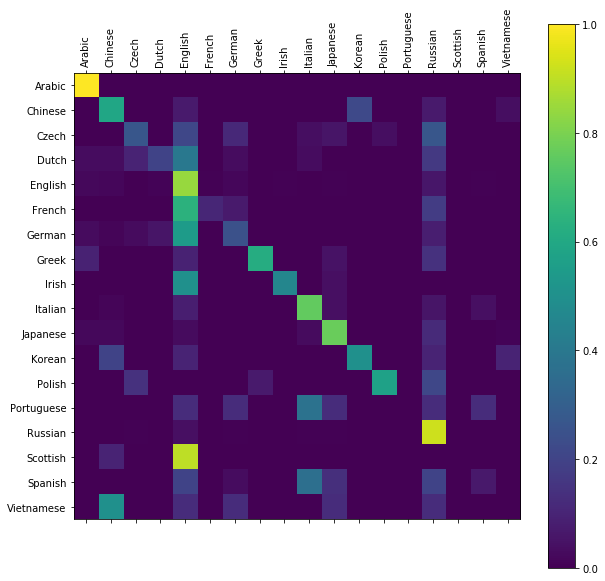

In [13]:
show_confusion(model, train_loader, languages, num_classes)